# Water Potability

## Data import

In [1]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
#Imports
import numpy as np
import pandas as pd
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
import warnings
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_csv('drinking_water_potability.csv')
X = data.drop(columns = ['Potability'])
y = data['Potability']

## Data visualisation

In [5]:
print(data.shape)
data.head()

(3276, 10)


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


9 features numériques et 1 target catégorielle binaire, on voit qu'il y a des données manquantes, il faudra traiter ce problème.

### Données aberrantes

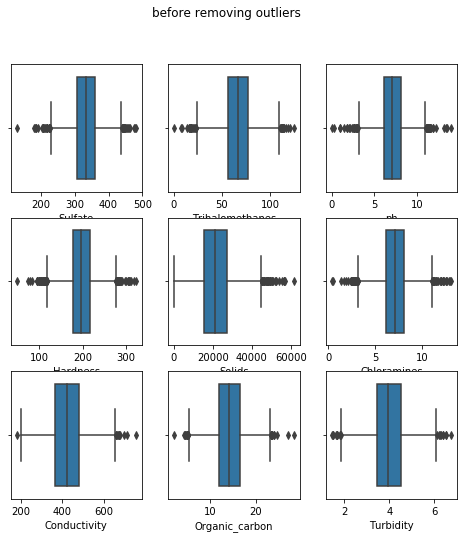

In [6]:
fig, axes = plt.subplots(3, 3,figsize=(8, 8))
fig.suptitle('before removing outliers')
sns.boxplot(X["Sulfate"],ax=axes[0][0])
sns.boxplot(X["Trihalomethanes"],ax=axes[0][1])
sns.boxplot(X["ph"],ax=axes[0][2])
sns.boxplot(X["Hardness"],ax=axes[1][0])
sns.boxplot(X["Solids"],ax=axes[1][1])
sns.boxplot(X["Chloramines"],ax=axes[1][2])
sns.boxplot(X["Conductivity"],ax=axes[2][0])
sns.boxplot(X["Organic_carbon"],ax=axes[2][1])
sns.boxplot(X["Turbidity"],ax=axes[2][2])

plt.show()

Quelques outliers qu'il faudra peut être enlever.

### Valeurs manquantes

In [7]:
for col in X.columns:
    missing = sum(~pd.notna(X[col]))
    total = X.shape[0]
    print(col,'missing values : {} out of {} ({}%)'.format(missing, total, round(100*missing/total)))

ph missing values : 491 out of 3276 (15%)
Hardness missing values : 0 out of 3276 (0%)
Solids missing values : 0 out of 3276 (0%)
Chloramines missing values : 0 out of 3276 (0%)
Sulfate missing values : 781 out of 3276 (24%)
Conductivity missing values : 0 out of 3276 (0%)
Organic_carbon missing values : 0 out of 3276 (0%)
Trihalomethanes missing values : 162 out of 3276 (5%)
Turbidity missing values : 0 out of 3276 (0%)


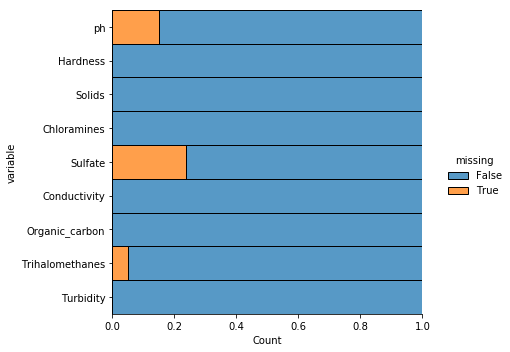

In [8]:
sns.displot(
    data=X.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)

On&nbsp;a&nbsp;des&nbsp;valeurs&nbsp;manquantes&nbsp;sur&nbsp;3&nbsp;des&nbsp;9&nbsp;features à hauteur de 5% (Trihalomethanes), 15% (ph) et 25% (Sulfate).

In [9]:
for col in X.columns:
    missing_potable = sum(~pd.notna(X.loc[y == 1,col]))
    total = sum(y == 1)
    print(col,'Potable missing values : {} out of {} ({}%)'.format(missing_potable, total, round(100*missing_potable/total)))

ph Potable missing values : 177 out of 1278 (14%)
Hardness Potable missing values : 0 out of 1278 (0%)
Solids Potable missing values : 0 out of 1278 (0%)
Chloramines Potable missing values : 0 out of 1278 (0%)
Sulfate Potable missing values : 293 out of 1278 (23%)
Conductivity Potable missing values : 0 out of 1278 (0%)
Organic_carbon Potable missing values : 0 out of 1278 (0%)
Trihalomethanes Potable missing values : 55 out of 1278 (4%)
Turbidity Potable missing values : 0 out of 1278 (0%)


In [10]:
for col in X.columns:
    missing_non_potable = sum(~pd.notna(X.loc[y == 0,col]))
    total = sum(y == 0)
    print(col,'Non potable missing values : {} out of {} ({}%)'.format(missing_non_potable, total, round(100*missing_non_potable/total)))

ph Non potable missing values : 314 out of 1998 (16%)
Hardness Non potable missing values : 0 out of 1998 (0%)
Solids Non potable missing values : 0 out of 1998 (0%)
Chloramines Non potable missing values : 0 out of 1998 (0%)
Sulfate Non potable missing values : 488 out of 1998 (24%)
Conductivity Non potable missing values : 0 out of 1998 (0%)
Organic_carbon Non potable missing values : 0 out of 1998 (0%)
Trihalomethanes Non potable missing values : 107 out of 1998 (5%)
Turbidity Non potable missing values : 0 out of 1998 (0%)


On voit qu'on a sensiblement les mêmes proportions de valeurs manquantes sur les mêmes features parmi les instances potables d'une part et non potable d'autre part.

Pour gérer ce problème des datas manquantes plusieurs solutions s'offrent à nous : 

- Listwise deletion : supprimer les lignes de données manquantes (on ne va pas privilégier cette solution ici car on a assez peu d'instances, et il serait bien d'être capable de fournir une prédiction même pour les instances qui pourraient avoir des valeurs manquantes).

- Univariate feature imputation : Remplacer les données manquantes de chaque feature en utilisant les valeurs observées de ce même feature (remplacer par la moyenne ou la médiane etc ..)

- Multivariate feature imputation: Remplacer les données manquantes de chaque feature en utilisant les valeurs obervées des autres features (avec un KNN ou un iterative imputer)

### Equilibre des données 

data labélisé potable 1278 39.010989010989015 %, et non potable 1998 60.98901098901099 %


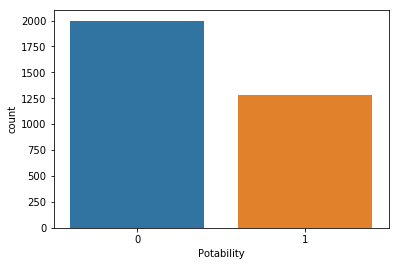

In [12]:
sns.countplot(y)
print("data labélisé potable",y.sum(),y.sum()/y.shape[0]*100,"%, et non potable",y.shape[0]-y.sum(),(y.shape[0]-y.sum())/y.shape[0]*100,"%")

Data&nbsp;set&nbsp;légèrement déséquilibré,&nbsp;l'algorithme&nbsp;qui&nbsp;mettrait&nbsp;toutes&nbsp;les&nbsp;instances&nbsp;à&nbsp;0&nbsp;aurait&nbsp;une&nbsp;accuracy&nbsp;de&nbsp;61%

Ici pour rééquilibrer les données, nous avons opté pour de l'upscaling. La solution de downscaling ne nous satisfaisait pas car cela nous ferait supprimer des instances alors que le dataset est déjà de taille assez réduite.

### Distribution des datas

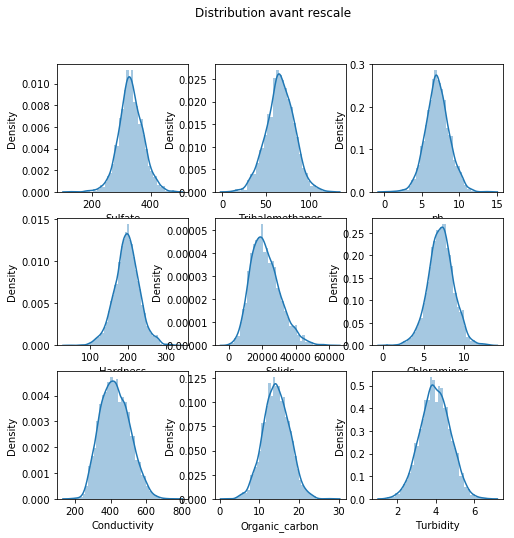

In [13]:
data_sans_missing_values=X.copy()
index_with_nan = data_sans_missing_values.index[data_sans_missing_values.isnull().any(axis=1)]
index_with_nan.shape
data_sans_missing_values.drop(index_with_nan,0, inplace=True)

fig, axes = plt.subplots(3, 3,figsize=(8, 8))
fig.suptitle('Distribution avant rescale')
sns.distplot(data_sans_missing_values["Sulfate"],ax=axes[0][0])
sns.distplot(data_sans_missing_values["Trihalomethanes"],ax=axes[0][1])
sns.distplot(data_sans_missing_values["ph"],ax=axes[0][2])
sns.distplot(X["Hardness"],ax=axes[1][0])
sns.distplot(X["Solids"],ax=axes[1][1])
sns.distplot(X["Chloramines"],ax=axes[1][2])
sns.distplot(X["Conductivity"],ax=axes[2][0])
sns.distplot(X["Organic_carbon"],ax=axes[2][1])
sns.distplot(X["Turbidity"],ax=axes[2][2])

plt.show()

Les datas sont toutes distribuées selon une pseudo gaussienne. Les amplitudes des données sont variables allant jusqu'à 60 000 pour "Solids". Il faudra donc remettre ces données à la même échelle. On utilisera StandardScaler pour la mise à l'échelle car les données semblent ici globalement normalement distribuées.

### Corrélation entre les features

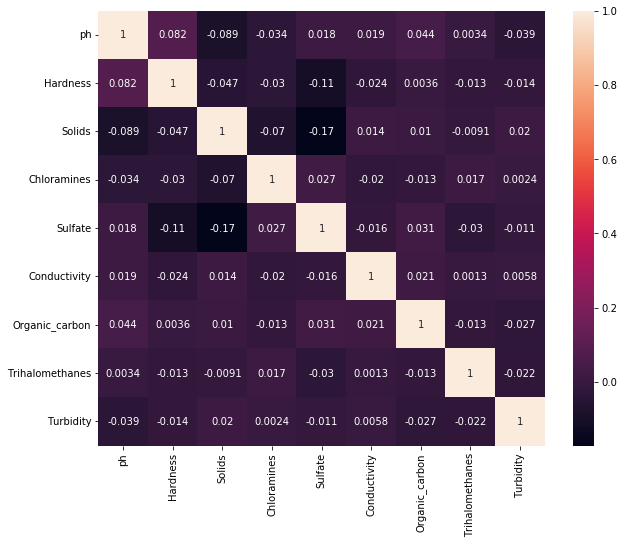

In [14]:
plt.figure(figsize=(10,8))
sns.heatmap(X.corr(), annot=True)

Aucune corrélation apparente entre les features.

## Fonctions prétraitement

### Gestion des données aberrantes

In [15]:
def handle_outliers(X1,y1,features_quantiles):
    
    list_quantiles = []
    for comb in features_quantiles:
        Q3 = X1[comb[0]].quantile(1-comb[1])
        Q1 = X1[comb[0]].quantile(comb[1])
        list_quantiles.append((Q1,Q3))
    
    for i in range(len(list_quantiles)):
        y1 = y1[(X1[features_quantiles[i][0]] <= list_quantiles[i][1]) & (X1[features_quantiles[i][0]] >= list_quantiles[i][0]) | ~pd.notna(X1[features_quantiles[i][0]])]
        X1 = X1[(X1[features_quantiles[i][0]] <= list_quantiles[i][1]) & (X1[features_quantiles[i][0]] >= list_quantiles[i][0]) | ~pd.notna(X1[features_quantiles[i][0]])]

    return X1,y1

### Données manquantes

In [16]:
def handle_missing_values(X1,X1_test,method):
    columns = X1.columns
    if method=="Univariate":
        imp_mean = SimpleImputer()
        X1 = imp_mean.fit_transform(X1)
        X1_test = imp_mean.transform(X1_test)
        
    elif method=="Iterative":
        columns = X1.columns
        it_imp = IterativeImputer()
        X1 = it_imp.fit_transform(X1)
        X1_test = it_imp.transform(X1_test)
        
    elif method=="KNN":
        # Init the transformer
        impKNN = KNNImputer()

        # Fit/transform
        colunms=X1.columns
        X1=impKNN.fit_transform(X1)
        X1_test=impKNN.fit_transform(X1_test)

    return pd.DataFrame(X1, columns = columns),pd.DataFrame(X1_test, columns = columns)

### Rééquilibrage des classes

In [17]:
def handle_balancing(X1,y1):
    oversample = SMOTE()
    X1, y1 = oversample.fit_resample(X1, y1)
    return X1,y1

### Mise à l'échelle

In [18]:
def handle_rescaling(X1,X1_test,method):
    columns = X1.columns
    if method == 'StandardScaler':
        scaler = StandardScaler()
        X1 = scaler.fit_transform(X1)
        X1_test = scaler.transform(X1_test)
    elif method == 'MinMaxScaler':
        scaler = MinMaxScaler()
        X1 = scaler.fit_transform(X1)
        X1_test = scaler.transform(X1_test)
    return pd.DataFrame(X1, columns = columns),pd.DataFrame(X1_test, columns = columns)

## Data prétraitement

### Paramètres de prétraitement

In [19]:
#Preprocessing parameters

outliers = False
rescale = True
missing_values = True
upscaling = False 

features_quantiles = []
test_size = 0.15
split_seed = 0
rescale_method = 'StandardScaler'
imputation_method = 'KNN'

### Gestion des données aberrantes

In [20]:
if outliers:
    fig, axes = plt.subplots(3, 3,figsize=(8, 8))
    fig.suptitle('avant gestion des outliers')
    sns.boxplot(X["Sulfate"],ax=axes[0][0])
    sns.boxplot(X["Trihalomethanes"],ax=axes[0][1])
    sns.boxplot(X["ph"],ax=axes[0][2])
    sns.boxplot(X["Hardness"],ax=axes[1][0])
    sns.boxplot(X["Solids"],ax=axes[1][1])
    sns.boxplot(X["Chloramines"],ax=axes[1][2])
    sns.boxplot(X["Conductivity"],ax=axes[2][0])
    sns.boxplot(X["Organic_carbon"],ax=axes[2][1])
    sns.boxplot(X["Turbidity"],ax=axes[2][2])

    plt.show()

    X,y = handle_outliers(X,y,features_quantiles)

    fig, axes = plt.subplots(3, 3,figsize=(8, 8))
    fig.suptitle('après gestion des outliers')
    sns.boxplot(X["Sulfate"],ax=axes[0][0])
    sns.boxplot(X["Trihalomethanes"],ax=axes[0][1])
    sns.boxplot(X["ph"],ax=axes[0][2])
    sns.boxplot(X["Hardness"],ax=axes[1][0])
    sns.boxplot(X["Solids"],ax=axes[1][1])
    sns.boxplot(X["Chloramines"],ax=axes[1][2])
    sns.boxplot(X["Conductivity"],ax=axes[2][0])
    sns.boxplot(X["Organic_carbon"],ax=axes[2][1])
    sns.boxplot(X["Turbidity"],ax=axes[2][2])

    plt.show()

### Séparation données d'entrainement et de test

Nous avons décidé de séparer les données de test et d'entrainement maintenant car nous ne voulons pas apprendre notre modèle sur les données de test. La gestion des données aberrante peut se faire sur l'ensemble du data set car le faire seulement sur les données d'entrainement créerait beaucoup de variance entre les 2 jeux de données. Pour la gestion des données manquantes et la mise à l'échelle (respectivement le rééquilibrage des classes) nous préférons séparer données de test et d'entrainement pour ne pas apprendre des données de test (respectivement pour ne pas fausser les données du test set).

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=split_seed)

### Mise à l'échelle

In [22]:
if rescale:
    print("train set avant mise à l'échelle\n")
    print(X_train.head(),"\n")
    X_train,X_test = handle_rescaling(X_train,X_test,rescale_method)
    print("train set après mise à l'échelle\n")
    print(X_train.head(),"\n")

train set avant mise à l'échelle

            ph    Hardness        Solids  Chloramines     Sulfate  \
3260       NaN  134.736856   9000.025591     9.026293         NaN   
3193  6.150034  188.413055   8406.723244     7.744714  358.591738   
719        NaN  160.325972  37795.763320     9.152225  390.276608   
1160  7.808641  200.714870  15694.507190     7.219558         NaN   
2475  4.991397  141.622395  44499.728710     8.260928  335.509830   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  
3260    428.213987        8.668672        74.773392   3.699558  
3193    449.358812       13.220295        52.956632   3.444442  
719     441.986106       16.450990        21.355275   4.441980  
1160    519.862992       13.262102        79.344915   2.472720  
2475    534.711454       15.350873        62.896558   3.926599   

train set après mise à l'échelle

         ph  Hardness    Solids  Chloramines   Sulfate  Conductivity  \
0       NaN -1.900258 -1.475085     1.189830       Na

### Données manquantes

In [23]:
if missing_values:
    print("train set avant gestion des données manquantes\n")
    print(X_train.head(),"\n")
    X_train, X_test = handle_missing_values(X_train,X_test,imputation_method)
    print("train set après gestion des données manquantes\n")
    print(X_train.head(),"\n")

train set avant gestion des données manquantes

         ph  Hardness    Solids  Chloramines   Sulfate  Conductivity  \
0       NaN -1.900258 -1.475085     1.189830       NaN      0.033693   
1 -0.590623 -0.258579 -1.542752     0.391515  0.600266      0.295262   
2       NaN -1.117618  1.809100     1.268275  1.363519      0.204059   
3  0.453133  0.117670 -0.711572     0.064388       NaN      1.167423   
4 -1.319750 -1.689665  2.573695     0.713073  0.044249      1.351104   

   Organic_carbon  Trihalomethanes  Turbidity  
0       -1.692011         0.507804  -0.352104  
1       -0.321360        -0.833944  -0.679546  
2        0.651514        -2.777453   0.600796  
3       -0.308770         0.788956  -1.926754  
4        0.320231        -0.222631  -0.060697   

train set après gestion des données manquantes

         ph  Hardness    Solids  Chloramines   Sulfate  Conductivity  \
0 -1.217933 -1.900258 -1.475085     1.189830  0.350415      0.033693   
1 -0.590623 -0.258579 -1.542752     0

### Upscaling

In [24]:
if upscaling:
    print("labels d'entrainement avant upscaling")
    sns.countplot(y_train)
    plt.show()
    X_train, y_train = handle_balancing(X_train,y_train)
    print("labels d'entrainement après upscaling")
    sns.countplot(y_train)
    plt.show()

### Redéfinition des index

In [25]:
X_train.index = range(X_train.shape[0])
X_test.index = range(X_test.shape[0])
y_train.index = range(y_train.shape[0])
y_test.index = range(y_test.shape[0])

## Sélection de modèles

In [26]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import classification_report

### SVC

In [27]:
from sklearn import svm
from sklearn.metrics import log_loss

In [28]:
fit_grid_init = True
fit_grid_2 = True
fit_grid_3 = True

###NE PAS RERUN LES GRID SEARCH###

In [29]:
svc = svm.SVC(probability=True,random_state=0)

In [ ]:
if fit_grid_init:
    params = [{'C' : [0.1,1,10,50,100], 'kernel' : ['rbf','sigmoid']},
          {'C' : [0.1,1,10,50,100], 'kernel' : ['poly'], 'degree' : [2,3]}]
    grid = GridSearchCV(svc,params,scoring = 'neg_log_loss',n_jobs=4,verbose=10)
    grid.fit(X_train,y_train)
    print("best params 1st grid :\n")
    print(grid.best_params_,"\n")
    print("cv results 1st grid :\n")
    print(grid.cv_results_,"\n")

    params_linear = {'kernel' : ['linear'], 'C' : [0.1,1,10,50]}
    grid_linear = GridSearchCV(svc,params_linear,scoring = 'neg_log_loss',n_jobs=4,verbose=10)
    grid_linear.fit(X_train,y_train)
    print("cv results 2nd grid :\n")
    print(grid_linear.cv_results_,"\n")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
best params 1st grid :

{'C': 1, 'kernel': 'rbf'} 

cv results 1st grid :

{'mean_fit_time': array([  6.41728945,   6.79939961,   6.23142409,   7.68143778,
        12.83247919,   7.82268825,  22.06519394,   7.61441984,
        21.92516398,   4.62476254,   3.60964165,   4.0544651 ,
         3.90136113,   5.37497873,   6.26078148,  21.46521235,
        15.23078604, 113.63628464,  25.5677599 , 253.16005039]), 'std_fit_time': array([ 0.47267054,  0.45419695,  0.35385158,  1.05443955,  0.11568605,
        0.22668726,  0.55568251,  0.20756695,  1.70253848,  0.48183564,
        0.317388  ,  0.45597815,  0.18840071,  0.41275644,  0.46758702,
        1.11654918,  0.55422698, 14.48860046,  1.44177983, 58.06204702]), 'mean_score_time': array([0.36932707, 0.2886796 , 0.30388708, 0.39810781, 0.51087146,
       0.3534246 , 0.43896065, 0.2984673 , 0.25031648, 0.1669446 ,
       0.14575653, 0.1299202 , 0.15339894, 0.14440837, 0.12087889,
  

Compte tenu des résultats des précédents grid search, nous allons explorer le svc avec kernel = 'rbf' et C autour de 1.

In [ ]:
if fit_grid_2:
    params_2 = {'C' : [0.5,1,3,5], 
    'kernel' : ['rbf'], 
    'gamma' : ['auto','scale'], 
    'class_weight' : ['balanced',None,{0 : 1, 1 : 2},{0 : 1, 1 : 0.5},{0 : 1, 1 : 10},{0 : 1, 1 : 0.1}]}
    grid_2 = GridSearchCV(svc,params_2,scoring = 'neg_log_loss',n_jobs=4,verbose=10)
    grid_2.fit(X_train,y_train)
    print("best params 3rd grid :\n")
    print(grid_2.best_params_,"\n")
    print("cv results 3rd grid :\n")
    print(grid_2.cv_results_,"\n")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
best params 3rd grid :

{'C': 1, 'class_weight': None, 'gamma': 'auto', 'kernel': 'rbf'} 

cv results 3rd grid :

{'mean_fit_time': array([12.09535761, 11.97802906, 11.16969018, 10.45164413, 11.65062432,
       11.50990982, 10.34031544, 10.16995807, 11.89421577, 11.91172676,
       10.42784042, 10.54866204, 11.77464375, 11.6246624 , 10.83706026,
       10.94146848, 11.99480324, 11.82800531, 10.8678977 , 10.57654839,
       12.56384945, 12.56276646, 10.73909817, 10.96357441, 11.99361672,
       12.03970556, 11.55436206, 11.26452904, 12.02047901, 11.74858027,
       10.82638593, 10.86422324, 14.92884951, 13.87632375, 10.67172017,
       10.62054548, 12.14628   , 12.49197526, 11.80243602, 11.81756997,
       12.7932416 , 12.86668038, 11.79754391, 11.79241824, 15.50319862,
       14.80635819, 10.79323049, 10.49718981]), 'std_fit_time': array([0.42971564, 0.37476176, 0.11692987, 0.36061533, 0.30252549,
       0.32492184, 0.291454

Maintenant, réglons l'hyperparamètre tol

In [ ]:
if fit_grid_3:
    params_tol = {'C': [1], 
    'class_weight': [None], 
    'gamma': ['auto'], 
    'kernel': ['rbf'],
    'tol' : [10**(-i) for i in range(3,8)]}
    grid_tol = GridSearchCV(svc,params_tol,scoring = 'neg_log_loss',n_jobs=4,verbose=10)
    grid_tol.fit(X_train,y_train)
    print("best params 4th grid :\n")
    print(grid_tol.best_params_,"\n")
    print("cv results 4th grid :\n")
    print(grid_tol.cv_results_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
best params 4th grid :

{'C': 1, 'class_weight': None, 'gamma': 'auto', 'kernel': 'rbf', 'tol': 1e-07} 

cv results 4th grid :

{'mean_fit_time': array([11.1224731 , 11.50726771, 13.53775678, 14.27394137, 10.12790513]), 'std_fit_time': array([0.12360529, 0.40480114, 1.14665426, 0.51533391, 3.27368654]), 'mean_score_time': array([0.60293703, 0.59384575, 0.71391468, 0.64667525, 0.45319562]), 'std_score_time': array([0.06159717, 0.03045625, 0.13483344, 0.11056568, 0.17039088]), 'param_C': masked_array(data=[1, 1, 1, 1, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_class_weight': masked_array(data=[None, None, None, None, None],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=['auto', 'auto', 'auto', 'auto', 'auto'],
             mask=[False, False, False, False, False],
  

Compte tenu des résultats de la grid search sur tol, on voit que les log loss sont sensiblement égales et ne s'améliorent pas à partir de 1e-5. On fixe donc tol = 1e-5.

In [ ]:
best_svc = svm.SVC(probability=True,random_state=0,kernel='rbf',C=1,gamma='auto',class_weight=None,tol=1e-5)

In [ ]:
cv_accuracy = cross_val_score(best_svc,X_train,y_train)
print("mean cv score :", np.mean(cv_accuracy))

mean cv score : 0.6734910814615812


In [ ]:
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=test_size, random_state=split_seed)

In [ ]:
best_svc.fit(X_train_train,y_train_train)
y_train_val_pred = best_svc.predict(X_train_val)
print("val classification report :\n")
print(classification_report(y_train_val,y_train_val_pred))

val classification report :

              precision    recall  f1-score   support

           0       0.70      0.90      0.79       264
           1       0.67      0.35      0.46       154

    accuracy                           0.70       418
   macro avg       0.68      0.62      0.62       418
weighted avg       0.69      0.70      0.67       418



In [ ]:
best_svc.fit(X_train,y_train)

SVC(C=1, gamma='auto', probability=True, random_state=0, tol=1e-05)

In [ ]:
print("train score :",best_svc.score(X_train,y_train))
print("test score :",best_svc.score(X_test,y_test))

train score : 0.7280890804597702
test score : 0.6951219512195121


In [ ]:
y_train_pred = best_svc.predict(X_train)
print("train classification report :\n")
print(classification_report(y_train,y_train_pred),"\n")
y_test_pred = best_svc.predict(X_test)
print("test classification report :\n")
print(classification_report(y_test,y_test_pred))

train classification report :

              precision    recall  f1-score   support

           0       0.70      0.96      0.81      1690
           1       0.85      0.38      0.52      1094

    accuracy                           0.73      2784
   macro avg       0.77      0.67      0.67      2784
weighted avg       0.76      0.73      0.70      2784
 

test classification report :

              precision    recall  f1-score   support

           0       0.69      0.94      0.79       308
           1       0.74      0.28      0.41       184

    accuracy                           0.70       492
   macro avg       0.72      0.61      0.60       492
weighted avg       0.71      0.70      0.65       492



### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
fit_grid_init_rf=False

In [ ]:
if fit_grid_init_rf:
    rf = RandomForestClassifier(random_state = 7,n_jobs=4,criterion='entropy', max_features= 5, n_estimators= 250)
    grid_params = {'n_estimators' : range(10,100,10), 'criterion' : ['gini','entropy'], 'max_features' : range(1,10),'min_samples_leaf':range(10,100,10)}
    grid = GridSearchCV(rf,grid_params,scoring = 'neg_log_loss' ,n_jobs=-1)
    grid.fit(X_train,y_train)
    print("best params 1st grid :\n")
    print(grid.best_params_,"\n")

best params 1st grid :

{'criterion': 'gini', 'max_features': 7, 'min_samples_leaf': 10, 'n_estimators': 90} 



In [ ]:
best_rf=RandomForestClassifier(random_state = 7,n_jobs=4,criterion='gini', max_features= 7, n_estimators= 90,min_samples_leaf= 10)
best_rf.fit(X_train,y_train)

print("mean cv score :", np.mean(cross_val_score(best_rf,X_train,y_train)))
print("train score :",best_rf.score(X_train,y_train))
print("test score :",best_rf.score(X_test,y_test))

y_test_pred = best_rf.predict(X_test)
print("test classification report :\n")
print(classification_report(y_test,y_test_pred))

mean cv score : 0.6663065239011663
train score : 0.8649425287356322
test score : 0.6951219512195121
test classification report :

              precision    recall  f1-score   support

           0       0.70      0.91      0.79       308
           1       0.68      0.34      0.46       184

    accuracy                           0.70       492
   macro avg       0.69      0.62      0.62       492
weighted avg       0.69      0.70      0.66       492



In [ ]:
###NE PAS RERUN####

rf = RandomForestClassifier(random_state = 0,n_jobs=-1)
grid_params = {'n_estimators' : [500,1000,1500,2000,2500], 'criterion' : ['gini','entropy'], 'max_features' : range(1,10)}
grid = GridSearchCV(rf,grid_params,scoring = 'neg_log_loss' ,n_jobs=-1)
grid.fit(X_train,y_train)
print("best params 2nd grid :\n")
print(grid.best_params_,"\n")

best params 2nd grid :

{'criterion': 'entropy', 'max_features': 5, 'n_estimators': 500} 



In [ ]:
rf = RandomForestClassifier(random_state = 0,n_jobs=-1)
grid_params = {'n_estimators' : [100,250,500,750], 'criterion' : ['entropy'], 'max_features' : range(3,10)}
grid = GridSearchCV(rf,grid_params,scoring = 'neg_log_loss' ,n_jobs=-1)
grid.fit(X_train,y_train)
print("best params 3rd grid :\n")
print(grid.best_params_,"\n")
print(grid.cv_results_,"\n")

In [ ]:
rf = RandomForestClassifier(random_state = 0,n_jobs=-1,n_estimators=750,max_features=7,criterion='entropy')
param_grid = {'max_depth' : [None,5,10,15,20], 'min_samples_leaf' : [1,5,10]}
grid_2 = GridSearchCV(rf,param_grid,scoring = 'neg_log_loss' ,n_jobs=-1)
grid_2.fit(X_train,y_train)
print("best params 4th grid :\n")
print(grid_2.best_params_,"\n")

best params 4th grid :

{'max_depth': 15, 'min_samples_leaf': 1} 



In [ ]:
print(grid_2.cv_results_)

{'mean_fit_time': array([44.96332254, 47.36372557, 37.28577695, 19.31524091, 18.93265352,
       18.43143406, 32.10395117, 30.78681178, 28.97948041, 39.90419683,
       38.40497713, 34.76002173, 43.17517333, 39.39174981, 32.48106833]), 'std_fit_time': array([0.52291719, 4.68691409, 3.3154445 , 0.33382075, 0.35191331,
       0.20466525, 0.30909432, 0.39056829, 0.27986845, 0.41964359,
       1.91323887, 2.55335937, 0.48803351, 0.49789415, 4.40951734]), 'mean_score_time': array([0.57134161, 0.69203258, 0.53505678, 0.38250804, 0.46312914,
       0.39153986, 0.40086427, 0.49611449, 0.48971429, 0.48599162,
       0.50915866, 0.51993384, 0.53903046, 0.51345592, 0.49883027]), 'std_score_time': array([0.05792911, 0.17480715, 0.10524531, 0.06174636, 0.04554792,
       0.04920909, 0.04795025, 0.08160415, 0.06011007, 0.04398249,
       0.09163993, 0.04561919, 0.01698319, 0.03968833, 0.05930461]), 'param_max_depth': masked_array(data=[None, None, None, 5, 5, 5, 10, 10, 10, 15, 15, 15, 20,
         

In [ ]:
best_rf = RandomForestClassifier(random_state = 0,n_jobs=-1,n_estimators=750,max_features=7,criterion='entropy',max_depth=15, min_samples_leaf=1)

In [ ]:
best_rf.fit(X_train_train,y_train_train)
y_train_val_pred = best_rf.predict(X_train_val)
print("val classification report :\n")
print(classification_report(y_train_val,y_train_val_pred))

val classification report :

              precision    recall  f1-score   support

           0       0.71      0.86      0.77       264
           1       0.61      0.39      0.48       154

    accuracy                           0.68       418
   macro avg       0.66      0.62      0.63       418
weighted avg       0.67      0.68      0.66       418



In [ ]:
best_rf.fit(X_train,y_train)
print("mean cv score :", np.mean(cross_val_score(best_rf,X_train,y_train)))
print("train score :",best_rf.score(X_train,y_train))
print("test score :",best_rf.score(X_test,y_test))

y_test_pred = best_rf.predict(X_test)
print("test classification report :\n")
print(classification_report(y_test,y_test_pred))

mean cv score : 0.6666642987226019
train score : 0.9640804597701149
test score : 0.7012195121951219
test classification report :

              precision    recall  f1-score   support

           0       0.70      0.93      0.79       308
           1       0.72      0.33      0.45       184

    accuracy                           0.70       492
   macro avg       0.71      0.63      0.62       492
weighted avg       0.71      0.70      0.67       492



In [ ]:
y_train_pred = best_rf.predict(X_train)
print("train classification report :\n")
print(classification_report(y_train,y_train_pred))

train classification report :

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1690
           1       1.00      0.91      0.95      1094

    accuracy                           0.96      2784
   macro avg       0.97      0.95      0.96      2784
weighted avg       0.97      0.96      0.96      2784



### XGBoost 

In [ ]:
from xgboost import XGBClassifier

In [ ]:
fit_grid_init_xgb=True
if fit_grid_init_xgb:
    xgb = XGBClassifier()
    parameters = {'n_estimators':[100,200,400,600,800, 1000], 'max_depth':[3, 5, 7], 'learning_rate': [0.1,0.3, 0.5]}
    grid = GridSearchCV(xgb,parameters ,n_jobs=4)
    grid.fit(X_train,y_train)
    print("best params 1st grid :\n")
    print(grid.best_params_,"\n")



[21:42:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
best params 1st grid :

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100} 



In [ ]:
best_xgb=XGBClassifier(learning_rate= 0.1, max_depth= 5, n_estimators= 100)

In [ ]:
best_xgb.fit(X_train_train,y_train_train)
y_train_val_pred = best_xgb.predict(X_train_val)
print("val classification report :\n")
print(classification_report(y_train_val,y_train_val_pred))

[20:36:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
val classification report :

              precision    recall  f1-score   support

           0       0.69      0.85      0.76       264
           1       0.57      0.35      0.44       154

    accuracy                           0.67       418
   macro avg       0.63      0.60      0.60       418
weighted avg       0.65      0.67      0.64       418



In [ ]:
best_xgb.fit(X_train,y_train)

print("mean cv score :", np.mean(cross_val_score(best_xgb,X_train,y_train)))
print("train score :",best_xgb.score(X_train,y_train))
print("test score :",best_xgb.score(X_test,y_test))

y_test_pred = best_xgb.predict(X_test)
print("test classification report :\n")
print(classification_report(y_test,y_test_pred))

[13:54:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:54:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:54:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:54:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=72c779e5-4e17-4f09-900a-84980128fea3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>